In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd 
from shapely.geometry import Point
from multiprocessing import Pool
import matplotlib.pyplot as plt
!pwd

/home/bingyu/Documents/residual_demand/projects/bay_area_peer/simulation_outputs


In [6]:
edges = pd.read_csv('../network_inputs/edges_peer.csv')
edges['edge_str'] = edges['start_nid'].astype('str') + '-' + edges['end_nid'].astype('str')
edges = edges.set_index('edge_str')
edges.head(1)

,uniqueid,osmid,length,type,bridge,tunnel,lanes,maxspeed,capacity,fft,weight,start_nid,end_nid,start_sp,end_sp,geometry
edge_str,,,,,,,,,,,,,,,,
0-2,0,7714200,175.637,residential,NaN,NaN,1,25.0,950.0,15.715577,18.858693,0,2,1,3,"LINESTRING (-122.7694487 38.4353358, -122.7692..."


In [12]:
hour, quarter, scen_nm = 10, 3, 'ctpp_eq1_bld5_pip100_bb1'
res = pd.read_csv('edge_vol/edge_vol_hr{}_qt{}_{}.csv'.format(hour, quarter, scen_nm))
res['edge_str'] = res['start_nid'].astype('str') + '-' + res['end_nid'].astype('str')
res = res.set_index('edge_str')
res = res.join(edges[['geometry']])
res.to_csv('../visualization_outputs/edge_vol_geom/edge_vol_hr{}_qt{}_{}.csv'.format(hour, quarter, scen_nm))
res.head(1)

,start_nid,end_nid,veh_current,vol_true,vol_tot,flow,t_avg,geometry
edge_str,,,,,,,,
100064-194078,100064,194078,0,1,551,4.0,0.72,"LINESTRING (-121.9879652 37.3776668, -121.9879..."


In [5]:
for eq_i in [0]:
    for scen_id in ['bld5_pip100_bb1', 'bld4_pip3_bb0.5', 'bld3_pip1_bb0']:
        scen_nm = 'ctpp_eq{}_{}'.format(eq_i, scen_id)
        ### count travel demand
        try:
            trip_info = pd.read_csv('trip_info/trip_info_{}.csv'.format(scen_nm))
        except FileNotFoundError:
            continue
        od_cnt = trip_info.shape[0]
        ### count total travel time
        tot_travel_time = 0
        for hour in range(3,12):
            for quarter in range(4):
                try:
                    res = pd.read_csv('edge_vol/edge_vol_hr{}_qt{}_{}.csv'.format(hour, quarter, scen_nm))
                except FileNotFoundError:
                    continue
                tot_travel_time += np.sum(res['vol_true'] * res['t_avg'])/3600
        print(scen_nm, od_cnt, tot_travel_time, tot_travel_time/od_cnt, np.sum(trip_info['travel_time'])/3600, np.sum(trip_info['travel_time'])/(3600*od_cnt), np.sum(trip_info['travel_time_used'])/3600, np.sum(trip_info['travel_time_used'])/(3600*od_cnt))

ctpp_eq0_bld5_pip100_bb1 2046332 748138.8596472222 0.36559994157703746 1005849.25 0.4915376634876452 744671.3049618214 0.36390541953203165
ctpp_eq0_bld4_pip3_bb0.5 1858020 666576.0741944445 0.3587561351301086 900401.75 0.48460282989418846 662601.619430234 0.3566170544075058
ctpp_eq0_bld3_pip1_bb0 1707040 640813.195911111 0.3753943644619405 858226.25 0.5027569652732214 632828.3987933245 0.37071679561892196


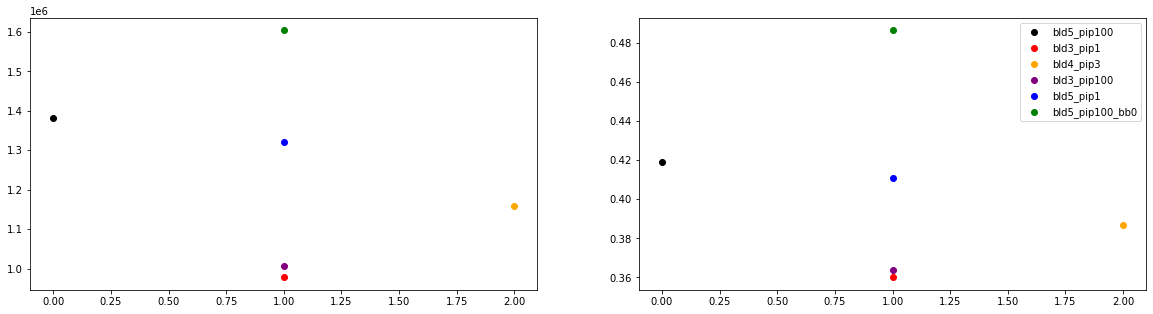

In [53]:
fig, ax = plt.subplots(1,2,figsize=(20, 5))
scen_dict = {'bld5_pip100': [0, 'k'], 'bld3_pip1': [1, 'r'], 'bld4_pip3': [2, 'orange'], 'bld3_pip100': [1, 'purple'], 'bld5_pip1': [1, 'blue'], 'bld5_pip100_bb0':[1, 'g']}

for eq_i in [0]:
    for scen_id in ['bld5_pip100', 'bld3_pip1', 'bld4_pip3', 'bld3_pip100', 'bld5_pip1', 'bld5_pip100_bb0']:
        scen_nm = 'eq{}_{}'.format(eq_i, scen_id)
        ### count travel demand
        trip_info = pd.read_csv('trip_info/trip_info_{}.csv'.format(scen_nm))
        od_cnt = trip_info.shape[0]
        tot_travel_time = np.sum(trip_info['travel_time_used'])/3600
        ax[0].scatter(scen_dict[scen_id][0], tot_travel_time, color=scen_dict[scen_id][1], label=scen_id)
        ax[1].scatter(scen_dict[scen_id][0], tot_travel_time/od_cnt, color=scen_dict[scen_id][1], label=scen_id)
plt.legend()
plt.show()


In [21]:
### node to tract
### read census tract geometry
census_tracts_gdf = gpd.read_file('../demand_inputs/traffic_inputs/census_tract.geojson')
census_tracts_gdf = census_tracts_gdf.to_crs(4326)
ba_census_tracts_gdf = census_tracts_gdf.loc[census_tracts_gdf['COUNTY'].isin(['001', '013', '041', '055', '075', '081', '085', '095', '097'])].copy().reset_index(drop=True)
ba_census_tracts_gdf['FIPS'] = ba_census_tracts_gdf['GEO_ID'].apply(lambda x: int(x.split('US')[1]))
print('Bay Area census tracts ', ba_census_tracts_gdf.shape)
ba_census_tracts_gdf.head(2)

### Find nodes inside each tract
def nodes_in_tract(tract_info):
    [tract_id, tract_geom] = tract_info
    coarse_match_ids = list(nodes_sindex.intersection(tract_geom.bounds))
    coarse_matchs = nodes_gdf.iloc[coarse_match_ids]
    precise_matches = coarse_matchs[coarse_matchs.intersects(tract_geom)]
    return (tract_id, precise_matches['osmid'].values.tolist())

nodes_df = pd.read_csv('../network_inputs/unique_id_nodes.csv')
display(nodes_df.head(2))
nodes_gdf = gpd.GeoDataFrame(nodes_df, crs=4326, geometry=[Point(xy) for xy in zip(nodes_df.lon, nodes_df.lat)])
nodes_sindex = nodes_gdf.sindex
print('finish spatial indexing')
pool = Pool(processes=5)
tract_info_list = ba_census_tracts_gdf[['FIPS', 'geometry']].values.tolist()
res = pool.imap_unordered(nodes_in_tract, tract_info_list)
pool.close()
pool.join()

# tract_nodes_dict = {tract_id: nodes_list for (tract_id, nodes_list) in res}
node_tract_dict = {node_id: tract_id for (tract_id, nodes_list) in res for node_id in nodes_list}
# print(len([i for v in tract_nodes_dict.values() for i in v]), nodes_gdf.shape)

Bay Area census tracts  (1585, 9)


,node_id_igraph,osmid,lon,lat
0,0,56098817,-122.769449,38.435336
1,1,65536002,-122.136780,37.407134


finish spatial indexing


In [43]:
node_osmid_dict = {getattr(n, 'node_id_igraph'): getattr(n, 'osmid') for n in nodes_gdf.itertuples()}
tract_geometry_dict = {getattr(tract, 'FIPS'): getattr(tract, 'geometry') for tract in ba_census_tracts_gdf.itertuples()}

In [46]:
scen_nm = 'eq0_bld3_pip1'
trip_info = pd.read_csv('trip_info/trip_info_{}.csv'.format(scen_nm))
trip_info['origin_tract'] = trip_info['origin_nid'].map(node_osmid_dict).map(node_tract_dict)
display(trip_info.head(2))

def tract_info_statistics(df):
    unarrived = df.loc[df['destin_nid']!=df['stop_nid']]
    arrived = df.loc[df['destin_nid']==df['stop_nid']]
    return pd.Series([unarrived.shape[0], np.mean(arrived['travel_time_used'])])

tract_trip_info = trip_info.groupby('origin_tract').apply(tract_info_statistics)
tract_trip_info.columns = ['unarrived', 'average_travel_time']
tract_trip_info['geometry'] = tract_trip_info.index.map(tract_geometry_dict)
display(tract_trip_info.head())
tract_trip_info.to_csv('trip_info/tract_trip_info_{}.csv'.format(scen_nm))

,Unnamed: 0,agent_id,origin_nid,destin_nid,travel_time,travel_time_used,stop_nid,origin_tract
0,0,0,166605,78205,1800.0,1799.27,78205,6013307205
1,1,1,7584,112966,9000.0,8125.51,112966,6085508202


,unarrived,average_travel_time,geometry
origin_tract,,,
6001400100,0.0,1608.651683,(POLYGON ((-122.2341855308442 37.8525443298395...
6001400200,0.0,1185.821982,(POLYGON ((-122.2525345233592 37.8511053793879...
6001400300,0.0,1244.179187,(POLYGON ((-122.2641695804703 37.8378713771489...
6001400400,0.0,1175.469892,(POLYGON ((-122.2608055412335 37.8486953795521...
6001400500,0.0,1065.457623,(POLYGON ((-122.2602325275737 37.8527433800966...
